In [ ]:
#American Electric Power (AEP)***
#CommonWealth Edison (ComEd)
#The Dayton Power and Light Company (DAYTON)
#Duke Energy Ohio/Kentucky (DEOK)
#Dominion Virginia Power (DOM)
#Duquesne Light Co. (DUQ)
#East kentucky Power Cooperative (EKPC)
#First Energy (FE)
#Northern Illinois Hub (IN)
#PJM East region: 2001-2018 (PJME)
#PJM West Region: 2001-2018 (PJMW)
#PJM Load Combined: 1998-2001 (PJM_load)



!pip install torch transformers

from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
plt.style.use('ggplot')



dataset_identifier = "robikscube/hourly-energy-consumption"

from google.colab import drive
drive.mount("/content/drive")

kaggle_creds_path = "/content/drive/My Drive/Dataset/kaggle.json"

! pip install kaggle --quiet

! mkdir ~/.kaggle
! cp "{kaggle_creds_path}" ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download -d {dataset_identifier}

! mkdir kaggle_data
! unzip "{dataset_identifier.split('/')[-1]}.zip" -d kaggle_data

drive.flush_and_unmount()



  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

**DATA EXPLORING**

In [ ]:
df = pd.read_csv('../content/kaggle_data/AEP_hourly.csv')
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace=True)


**Transformer**

In [ ]:
import numpy as np
import torch
from torch import nn, optim
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from math import sqrt
import matplotlib.pyplot as plt

class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_layers, output_dim, dropout=0.1):
        super(TimeSeriesTransformer, self).__init__()
        self.model_dim = model_dim
        self.embedding = nn.Linear(input_dim, model_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, batch_first=True, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(model_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        src = self.embedding(src) * torch.sqrt(torch.tensor(self.model_dim, dtype=torch.float32))
        src = self.dropout(src)
        output = self.transformer_encoder(src)
        output = self.fc_out(output[:, -1, :])  # Use the last output for prediction
        return output

def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i-n_steps:i])
        y.append(data[i])
    return np.array(X), np.array(y)


In [ ]:
#January 2017 to December 2017

from sklearn.preprocessing import MinMaxScaler
df = df.sort_index()
filtered_df = df.loc['2017-01-01':'2017-12-31']


train = filtered_df.loc['2017-01-01':'2017-09-30']
test = filtered_df.loc['2017-10-01':'2017-12-31']


scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train[['AEP_MW']])
test_scaled = scaler.transform(test[['AEP_MW']])

In [ ]:
n_steps = 24
X_train, y_train = create_sequences(train_scaled, n_steps)
X_test, y_test = create_sequences(test_scaled, n_steps)

# tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

X_train = X_train.reshape((X_train.shape[0], n_steps, 1))
X_test = X_test.reshape((X_test.shape[0], n_steps, 1))

In [ ]:

input_dim = 1
output_dim = 1


learning_rate = 0.0001
batch_size = 64
model_dim = 128
num_heads = 8
num_layers = 4
epochs = 20
dropout = 0.3

model_transformer = TimeSeriesTransformer(input_dim, model_dim, num_heads, num_layers, output_dim, dropout)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model_transformer.parameters(), lr=learning_rate, weight_decay=0.01)  # Added weight decay


early_stopping_patience = 5
best_loss = float('inf')
patience_counter = 0

def train_model(model, criterion, optimizer, X_train, y_train, X_val, y_val, epochs=20, batch_size=64):
    model.train()
    global best_loss, patience_counter
    for epoch in range(epochs):
        permutation = torch.randperm(X_train.size()[0])
        epoch_loss = 0
        for i in range(0, X_train.size()[0], batch_size):
            indices = permutation[i:i+batch_size]
            batch_x, batch_y = X_train[indices], y_train[indices]

            optimizer.zero_grad()
            output = model(batch_x)
            loss = criterion(output, batch_y)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / (X_train.size()[0] // batch_size)


        model.eval()
        with torch.no_grad():
            val_output = model(X_val)
            val_loss = criterion(val_output, y_val).item()

        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Val Loss: {val_loss:.4f}')


        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1

        if patience_counter >= early_stopping_patience:
            print("Early stopping")
            break


val_size = int(0.2 * len(X_train))
X_val, y_val = X_train[-val_size:], y_train[-val_size:]
X_train, y_train = X_train[:-val_size], y_train[:-val_size]

train_model(model_transformer, criterion, optimizer, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)

model_transformer.load_state_dict(torch.load('best_model.pth'))

model_transformer.eval()
with torch.no_grad():
    predicted_values_transformer = model_transformer(X_test).numpy()




predicted_values_transformer_shifted = np.roll(predicted_values_transformer, shift=-1, axis=0)
predicted_values_transformer_shifted = predicted_values_transformer_shifted[:-1]
predicted_values_transformer_shifted = scaler.inverse_transform(predicted_values_transformer_shifted)


y_test_original = scaler.inverse_transform(y_test.numpy().reshape(-1, 1)[:-1])








mse_transformer = mean_squared_error(y_test_original, predicted_values_transformer_shifted)
rmse_transformer = sqrt(mse_transformer)
mae_transformer = mean_absolute_error(y_test_original, predicted_values_transformer_shifted)
mape_transformer = mean_absolute_percentage_error(y_test_original, predicted_values_transformer_shifted)

print(f'Transformer Model - Shifted MSE: {mse_transformer}, RMSE: {rmse_transformer}, MAE: {mae_transformer}, MAPE: {mape_transformer}')

Epoch 1/20, Loss: 0.0882, Val Loss: 0.0099
Epoch 2/20, Loss: 0.0035, Val Loss: 0.0027
Epoch 3/20, Loss: 0.0020, Val Loss: 0.0025
Epoch 4/20, Loss: 0.0019, Val Loss: 0.0027
Epoch 5/20, Loss: 0.0020, Val Loss: 0.0030
Epoch 6/20, Loss: 0.0019, Val Loss: 0.0026
Epoch 7/20, Loss: 0.0020, Val Loss: 0.0025
Epoch 8/20, Loss: 0.0020, Val Loss: 0.0024
Epoch 9/20, Loss: 0.0020, Val Loss: 0.0025
Epoch 10/20, Loss: 0.0020, Val Loss: 0.0026
Epoch 11/20, Loss: 0.0021, Val Loss: 0.0026
Epoch 12/20, Loss: 0.0022, Val Loss: 0.0024
Epoch 13/20, Loss: 0.0020, Val Loss: 0.0030
Epoch 14/20, Loss: 0.0021, Val Loss: 0.0024
Epoch 15/20, Loss: 0.0021, Val Loss: 0.0029
Epoch 16/20, Loss: 0.0021, Val Loss: 0.0025
Epoch 17/20, Loss: 0.0021, Val Loss: 0.0040
Epoch 18/20, Loss: 0.0022, Val Loss: 0.0024
Epoch 19/20, Loss: 0.0021, Val Loss: 0.0026
Early stopping
Transformer Model - Shifted MSE: 2035.3592529296875, RMSE: 45.114955978363625, MAE: 38.669803619384766, MAPE: 0.002683058148249984


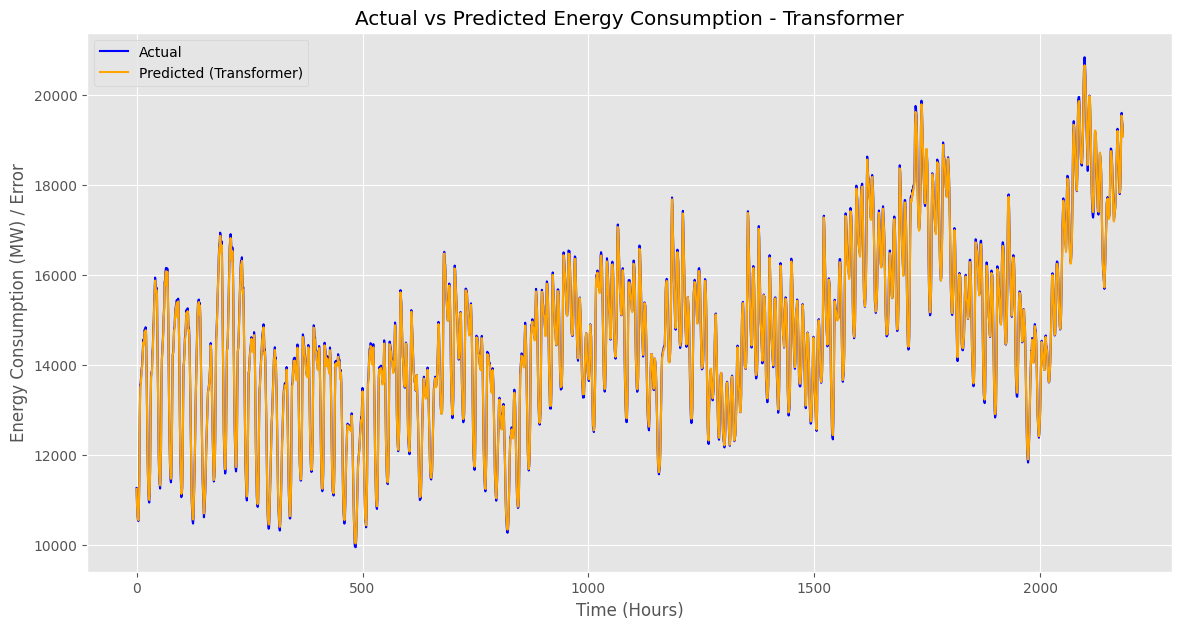

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(y_test_original , label='Actual', color='blue')
plt.plot(predicted_values_transformer_shifted, label='Predicted (Transformer)', color='orange')
plt.title('Actual vs Predicted Energy Consumption - Transformer')
plt.xlabel('Time (Hours)')
plt.ylabel('Energy Consumption (MW) / Error')
plt.legend()
plt.show()

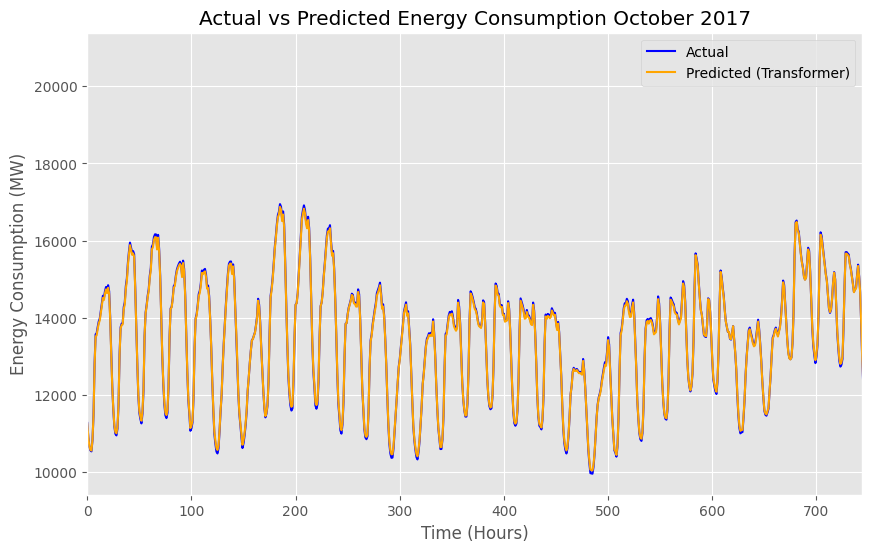

In [ ]:
# MONTH 1 (October)

plt.figure(figsize=(10, 6))
plt.plot(y_test_original , label='Actual', color='blue')
plt.plot(predicted_values_transformer_shifted, label='Predicted (Transformer)', color='orange')
plt.title('Actual vs Predicted Energy Consumption October 2017')
plt.xlabel('Time (Hours)')
plt.ylabel('Energy Consumption (MW)')
plt.legend()
plt.xlim(0, 744)
plt.show()


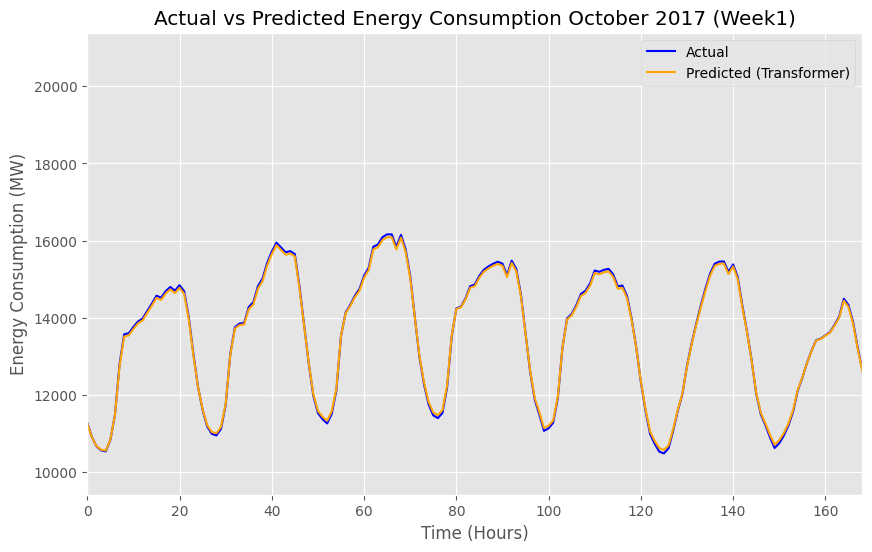

In [ ]:
# Month October week 1

plt.figure(figsize=(10, 6))
plt.plot(y_test_original , label='Actual', color='blue')
plt.plot(predicted_values_transformer_shifted, label='Predicted (Transformer)', color='orange')
plt.title('Actual vs Predicted Energy Consumption October 2017 (Week1)')
plt.xlabel('Time (Hours)')
plt.ylabel('Energy Consumption (MW)')
plt.legend()
plt.xlim(0, 168)
plt.show()


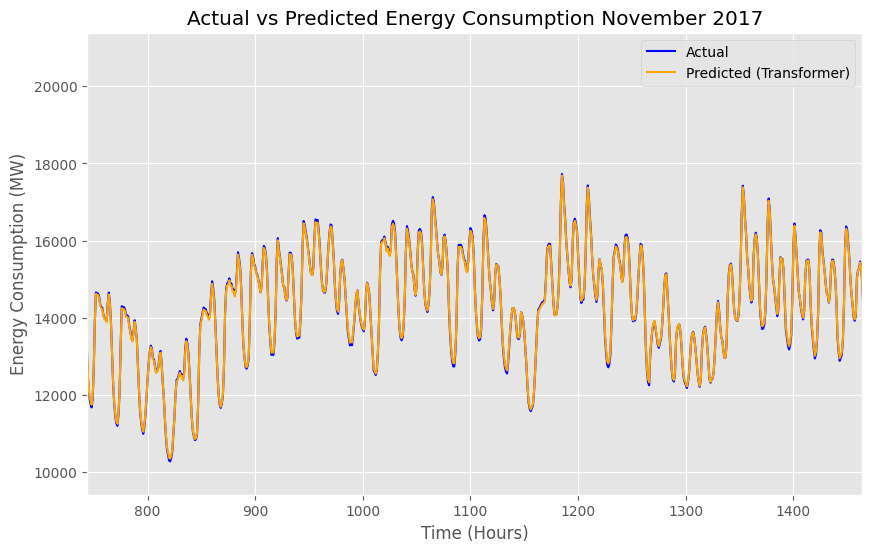

In [ ]:
# MoNTH 2 (November)

plt.figure(figsize=(10, 6))
plt.plot(y_test_original , label='Actual', color='blue')
plt.plot(predicted_values_transformer_shifted, label='Predicted (Transformer)', color='orange')
plt.title('Actual vs Predicted Energy Consumption November 2017')
plt.xlabel('Time (Hours)')
plt.ylabel('Energy Consumption (MW)')
plt.legend()
plt.xlim(744, 1464)
plt.show()


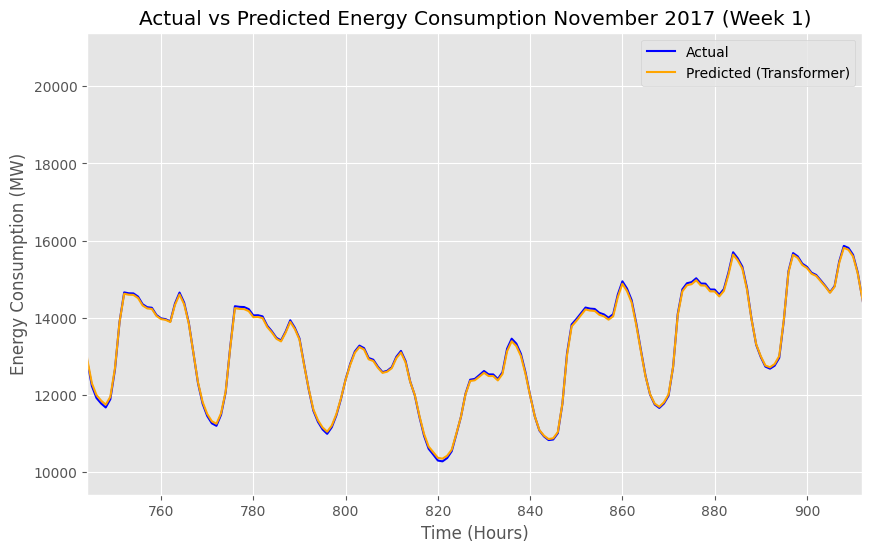

In [ ]:
# MoNTH 2 (November) Week 1

plt.figure(figsize=(10, 6))
plt.plot(y_test_original , label='Actual', color='blue')
plt.plot(predicted_values_transformer_shifted, label='Predicted (Transformer)', color='orange')
plt.title('Actual vs Predicted Energy Consumption November 2017 (Week 1)')
plt.xlabel('Time (Hours)')
plt.ylabel('Energy Consumption (MW)')
plt.legend()
plt.xlim(744, 912)
plt.show()


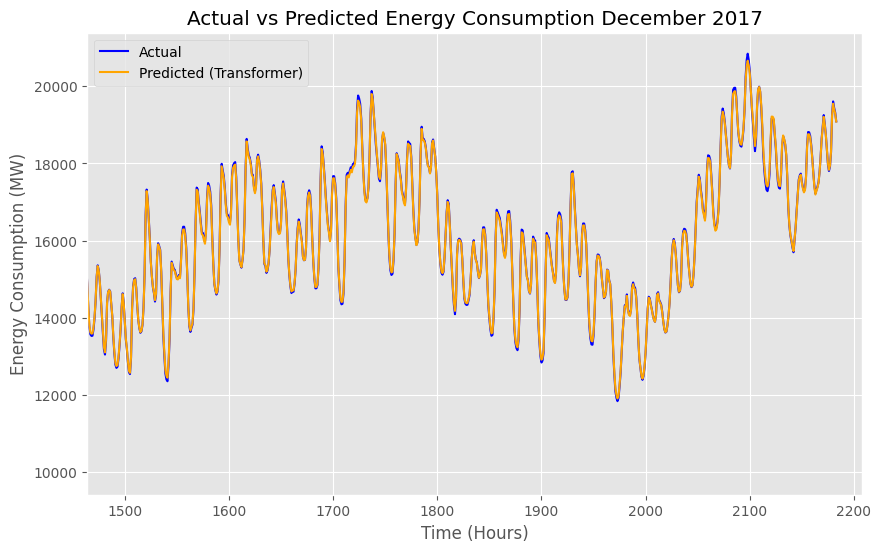

In [ ]:
# MONTH 3 (December)

plt.figure(figsize=(10, 6))
plt.plot(y_test_original , label='Actual', color='blue')
plt.plot(predicted_values_transformer_shifted, label='Predicted (Transformer)', color='orange')
plt.title('Actual vs Predicted Energy Consumption December 2017')
plt.xlabel('Time (Hours)')
plt.ylabel('Energy Consumption (MW)')
plt.legend()
plt.xlim(1464,2208)
plt.show()


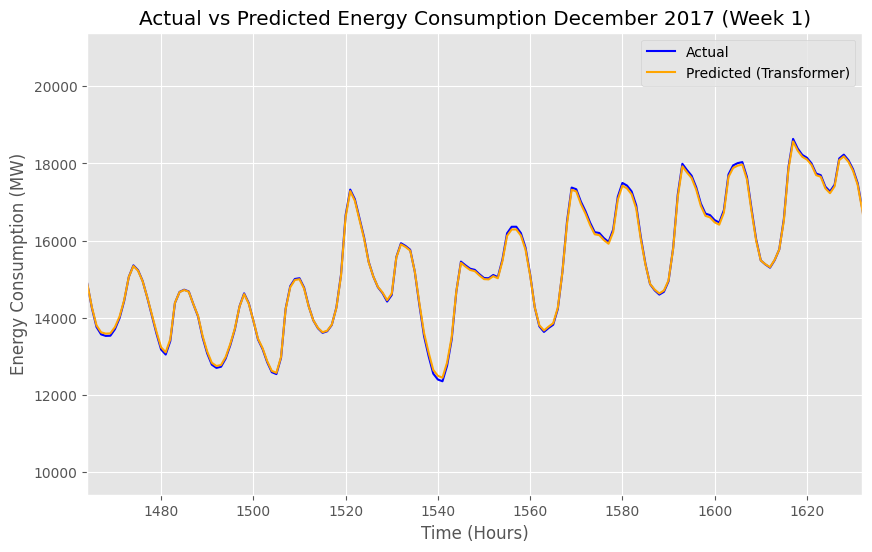

In [ ]:
# MONTH 3 (December) Week 1

plt.figure(figsize=(10, 6))
plt.plot(y_test_original , label='Actual', color='blue')
plt.plot(predicted_values_transformer_shifted, label='Predicted (Transformer)', color='orange')
plt.title('Actual vs Predicted Energy Consumption December 2017 (Week 1)')
plt.xlabel('Time (Hours)')
plt.ylabel('Energy Consumption (MW)')
plt.legend()
plt.xlim(1464,1632)
plt.show()


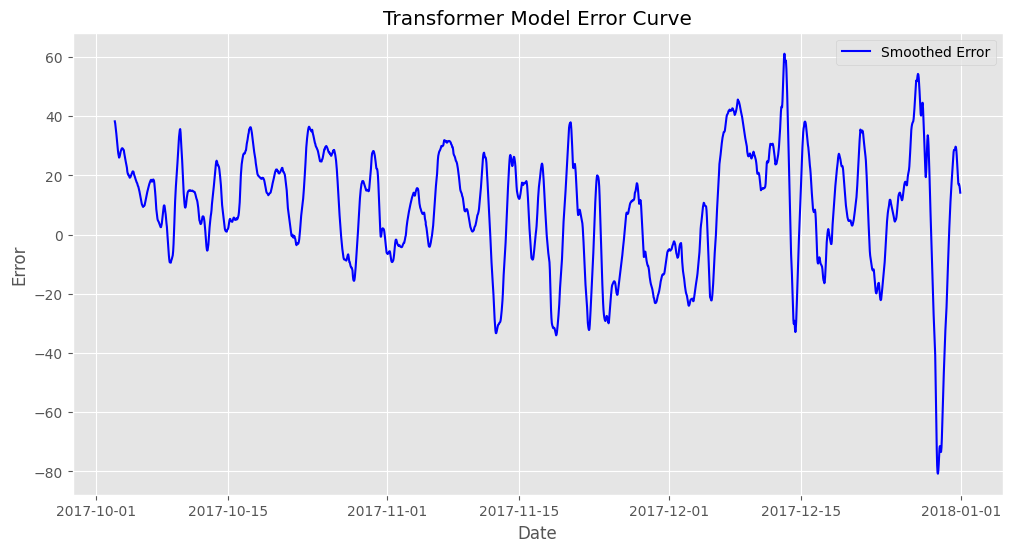

In [ ]:
errors_transformer = y_test_original.flatten() - predicted_values_transformer_shifted.flatten()


error_df_transformer = pd.DataFrame({
    'timestamp': test.index[n_steps + 1:],
    'original_values': y_test_original.flatten(),
    'transformer_predicted_values': predicted_values_transformer_shifted.flatten(),
    'errors': errors_transformer
})


error_df_transformer['smoothed_errors'] = error_df_transformer['errors'].rolling(window=24).mean()

# Plot the error curve
plt.figure(figsize=(12, 6))
plt.plot(error_df_transformer['timestamp'], error_df_transformer['smoothed_errors'], label='Smoothed Error', color='blue')
plt.xlabel('Date')
plt.ylabel('Error')
plt.title('Transformer Model Error Curve')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:

# Calculate errors and create the error DataFrame
errors_transformer = y_test_original.flatten() - predicted_values_transformer_shifted.flatten()

error_df_transformer = pd.DataFrame({
    'timestamp': test.index[n_steps + 1:],
    'original_values': y_test_original.flatten(),
    'transformer_predicted_values': predicted_values_transformer_shifted.flatten(),
    'errors': errors_transformer
})

error_df_transformer['smoothed_errors'] = error_df_transformer['errors'].rolling(window=24).mean()


# Adjust lengths of timestamps, original values, predicted values, and errors
timestamps = test.index[n_steps:]
print(f'Length of timestamps: {len(timestamps)}')
print(f'Length of original values: {len(y_test_original.flatten())}')
print(f'Length of predicted values: {len(predicted_values_transformer_shifted.flatten())}')

min_length = min(len(timestamps), len(y_test_original.flatten()), len(predicted_values_transformer_shifted.flatten()), len(error_df_transformer['smoothed_errors']))

timestamps_adjusted = timestamps[:min_length]
original_values_adjusted = y_test_original.flatten()[:min_length]
predicted_values_adjusted = predicted_values_transformer_shifted.flatten()[:min_length]
errors_adjusted = errors_transformer[:min_length]
smoothed_errors_adjusted = error_df_transformer['smoothed_errors'][:min_length]

# Create the results DataFrame including both errors and smoothed errors
results_df = pd.DataFrame({
    'timestamp': timestamps_adjusted,
    'original_values_Transformer': original_values_adjusted,
    'predicted_values_transformer': predicted_values_adjusted,
    'errors': errors_adjusted,
    'smoothed_errors': smoothed_errors_adjusted
})

# Mount Google Drive and save the DataFrame to CSV
drive.mount('/content/drive')
results_path = '/content/drive/My Drive/Transformer_model_predictions.csv'

if os.path.exists(results_path):
    existing_results_df = pd.read_csv(results_path)
    updated_results_df = pd.concat([existing_results_df, results_df], ignore_index=True)
    updated_results_df.to_csv(results_path, index=False)
else:
    results_df.to_csv(results_path, index=False)

drive.flush_and_unmount()


Length of timestamps: 2185
Length of original values: 2184
Length of predicted values: 2184
Mounted at /content/drive
